In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, split, lit, row_number
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
import seaborn as sns
from pyspark.sql.window import Window

In [2]:
spSession = SparkSession.builder.master("local").appName("Local-Session").getOrCreate()

In [3]:
# Loading files into a Data Frame

trainDF1 = spSession.read.csv("../dataset/train_2.csv", header = True) 
testDF1 = spSession.read.csv("../dataset/test_2.csv", header = True) 
type(trainDF1)

pyspark.sql.dataframe.DataFrame

In [4]:
# Converting string values to float

trainDF2 = trainDF1.select(*(col(c).cast("float").alias(c) for c in trainDF1.columns))
testDF2 = testDF1.select(*(col(c).cast("float").alias(c) for c in testDF1.columns)).orderBy("ID")

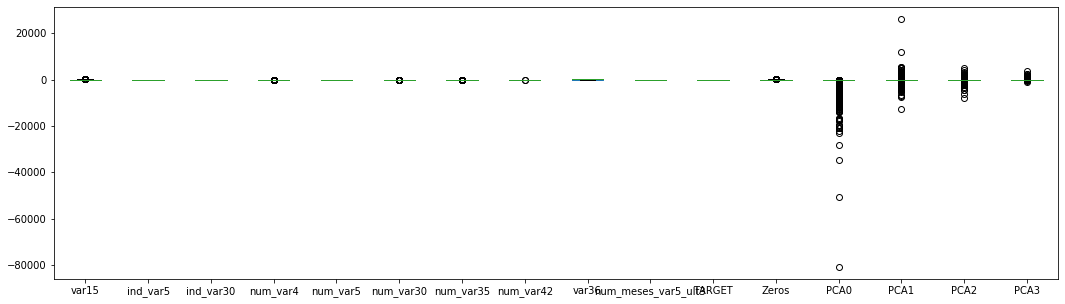

In [6]:
# Train data boxplot

trainDF2.toPandas().boxplot(grid = False, figsize = (18,5))

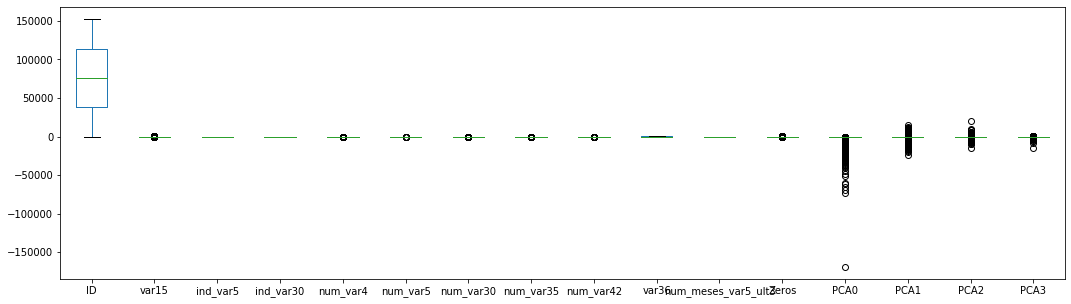

In [7]:
# Test data boxplot

testDF2.toPandas().boxplot(grid = False, figsize = (18,5))

In [17]:
# Normalizing data

vecAssembler = VectorAssembler(inputCols=trainDF2.drop("TARGET").columns, outputCol="features")
train_vector = vecAssembler.transform(trainDF2.drop("TARGET"))
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
train_model = scaler.fit(train_vector)
trainDF3 = train_model.transform(train_vector)
trainDF4 = sqlContext.createDataFrame([row.scaledFeatures.toArray().tolist() for row in trainDF3.collect()], 
                                      trainDF2.drop("TARGET").columns)                                    
                                      
vecAssembler = VectorAssembler(inputCols=testDF2.drop("ID").columns, outputCol="features")
test_vector = vecAssembler.transform(testDF2.drop("ID"))
test_model = scaler.fit(test_vector)
testDF3 = train_model.transform(test_vector)
testDF4 = sqlContext.createDataFrame([row.scaledFeatures.toArray().tolist() for row in testDF3.collect()], 
                                      testDF2.drop("ID").columns)

In [18]:
w = Window().orderBy(lit('A'))
trainDF5 = trainDF4.withColumn("ID_temp", row_number().over(w)).join(
    trainDF2.select("TARGET").withColumn("ID_temp", row_number().over(w)), on = "ID_temp").drop("ID_temp")
testDF5 = testDF4.withColumn("ID_temp", row_number().over(w)).join(
    testDF2.select("ID").withColumn("ID_temp", row_number().over(w)), on = "ID_temp").drop("ID_temp")

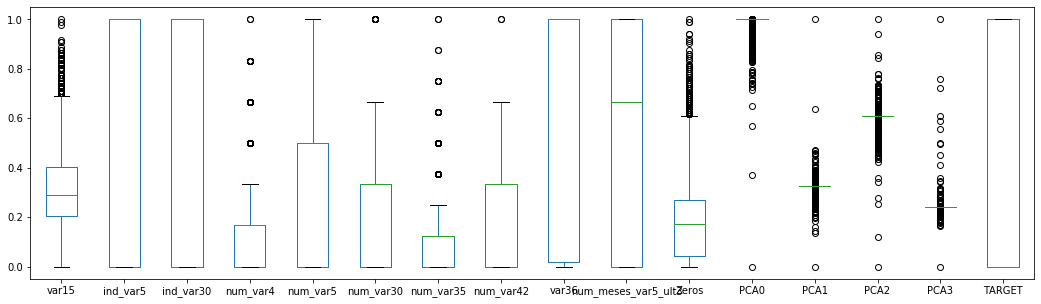

In [20]:
# Normalized train data

trainDF5.toPandas().boxplot(grid = False, figsize = (18,5))

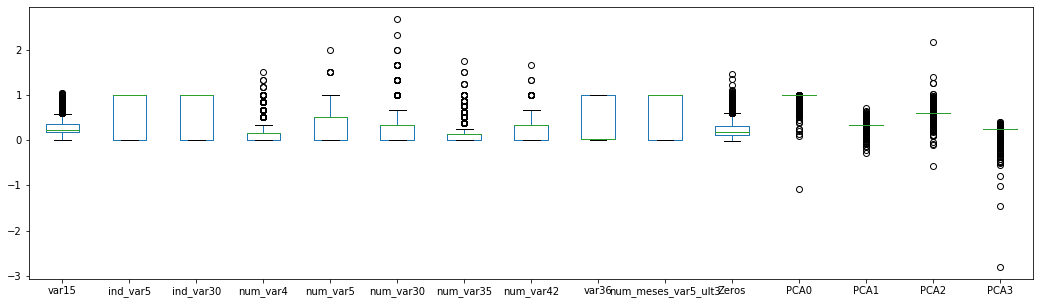

In [22]:
# Normalized test data

testDF5.drop("ID").toPandas().boxplot(grid = False, figsize = (18,5))

In [ ]:
# Making pairplot

#sns.pairplot(trainDF4.toPandas(), hue="TARGET", diag_kind = 'hist')

TARGET
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: var15, dtype: object

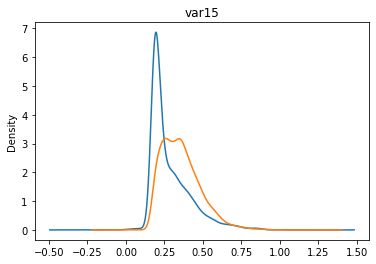

In [23]:
# Analysing var15

trainDF5.toPandas().groupby("TARGET").var15.plot(kind='kde', title = "var15")

TARGET
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: var15_level, dtype: object

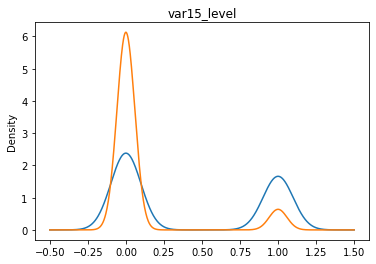

In [24]:
# Creating new variable

trainDF6 = trainDF5.withColumn("var15_level", when(col("var15") < 0.21, 1).otherwise(0))
testDF6 = testDF5.withColumn("var15_level", when(col("var15") < 0.21, 1).otherwise(0))
trainDF6.toPandas().groupby("TARGET").var15_level.plot(kind='kde', title = "var15_level")

TARGET
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Zeros, dtype: object

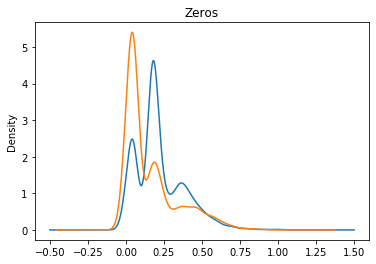

In [25]:
# Analysing Zeros

trainDF6.toPandas().groupby("TARGET").Zeros.plot(kind='kde', title = "Zeros")

TARGET
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Zeros_level, dtype: object

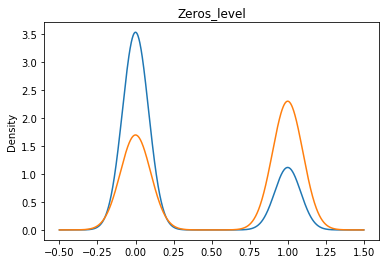

In [26]:
# Creating new variable

trainDF7 = trainDF6.withColumn("Zeros_level", when(col("Zeros") < 0.13, 1).otherwise(0))
testDF7 = testDF6.withColumn("Zeros_level", when(col("Zeros") < 0.13, 1).otherwise(0))
trainDF7.toPandas().groupby("TARGET").Zeros_level.plot(kind='kde', title = "Zeros_level")

In [27]:
# Checking correlation of remaining variables to the target variable

pd.Series([abs(trainDF7.corr("TARGET", col, method = "pearson")) for col in trainDF7.columns], 
          index = trainDF7.columns).sort_values()

PCA3                   0.013226
PCA2                   0.025067
PCA1                   0.030540
PCA0                   0.050579
Zeros                  0.180160
num_var35              0.194459
num_var4               0.199603
var36                  0.260567
var15                  0.266198
num_var5               0.327289
ind_var5               0.329948
num_var42              0.331228
Zeros_level            0.341456
ind_var30              0.348419
num_var30              0.348955
num_meses_var5_ult3    0.355075
var15_level            0.363460
TARGET                 1.000000
dtype: float64

In [28]:
# Saving data

trainDF7.write.csv("../dataset/train_3.csv", header = "true", mode = "overwrite")
testDF7.write.csv("../dataset/test_3.csv", header = "true", mode = "overwrite")